In [2]:
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00


In [7]:
import librosa
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

# 定义根目录（请根据实际情况调整路径）
root_folder = "../Data/inthewild/release_in_the_wild"


# 定义获取音频时长的函数
def get_audio_duration(file_path):
    try:
        return librosa.get_duration(filename=file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# 收集所有 .wav 文件的路径
file_paths = []
for dirpath, _, filenames in os.walk(root_folder):
    for f in filenames:
        if f.lower().endswith(".wav"):
            file_paths.append(os.path.join(dirpath, f))

print(f"总共找到 {len(file_paths)} 个 wav 文件.")

# 使用多线程提取时长（例如核心数设置为16）
durations = []
with ThreadPoolExecutor(max_workers=16) as executor:
    futures = {executor.submit(get_audio_duration, fp): fp for fp in file_paths}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        duration = future.result()
        if duration is not None:
            durations.append(duration)

print(f"成功提取时长的文件数量: {len(durations)}")


总共找到 31779 个 wav 文件.


/var/tmp/ipykernel_29856/3968953962.py:12: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  return librosa.get_duration(filename=file_path)


Processing files:   0%|          | 0/31779 [00:00<?, ?it/s]

成功提取时长的文件数量: 31779


98% 分位数: 14.86 s


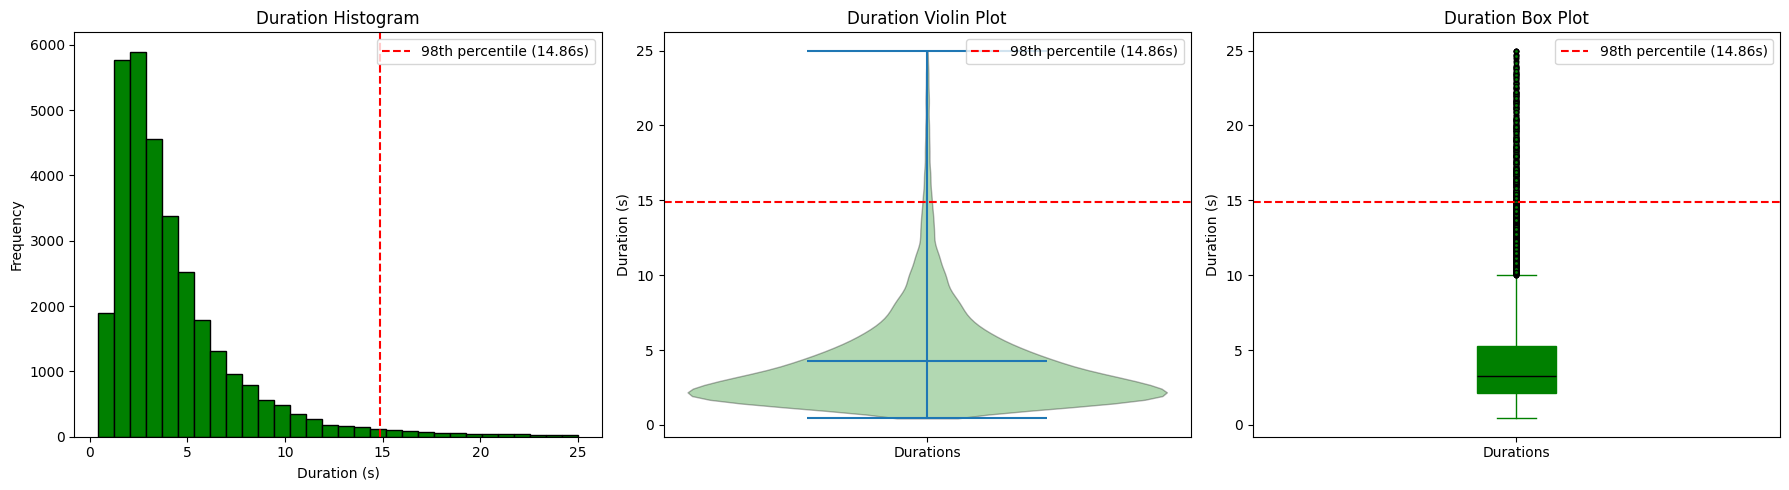

In [17]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# 假设 durations 列表已经存在
# durations = [...]

# 计算 98% 分位数
q98 = np.percentile(durations, 98)
print(f"98% 分位数: {q98:.2f} s")

# 创建 1 行 3 列的子图
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 直方图（x轴是时长，使用竖直线）
axs[0].hist(durations, bins=30, edgecolor='black', color='green')
axs[0].axvline(q98, color='red', linestyle='--', label=f"98th percentile ({q98:.2f}s)")
axs[0].legend()
axs[0].set_title("Duration Histogram")
axs[0].set_xlabel("Duration (s)")
axs[0].set_ylabel("Frequency")

# Violin图（数据沿 y 轴分布，添加水平线）
vp = axs[1].violinplot(durations, showmeans=True)
for body in vp['bodies']:
    body.set_facecolor('green')
    body.set_edgecolor('black')
axs[1].axhline(q98, color='red', linestyle='--', label=f"98th percentile ({q98:.2f}s)")
axs[1].legend()
axs[1].set_title("Duration Violin Plot")
axs[1].set_xticks([1])
axs[1].set_xticklabels(["Durations"])
axs[1].set_ylabel("Duration (s)")

# 箱线图（数据沿 y 轴分布，同样添加水平线）
box = axs[2].boxplot(durations,
                     patch_artist=True,
                     flierprops=dict(marker='o', markerfacecolor='green', markeredgecolor='black', markersize=3),
                     boxprops=dict(facecolor='green', color='green'),
                     whiskerprops=dict(color='green'),
                     capprops=dict(color='green'),
                     medianprops=dict(color='black'))
axs[2].axhline(q98, color='red', linestyle='--', label=f"98th percentile ({q98:.2f}s)")
axs[2].legend()
axs[2].set_title("Duration Box Plot")
axs[2].set_xticks([1])
axs[2].set_xticklabels(["Durations"])
axs[2].set_ylabel("Duration (s)")

plt.tight_layout()
# plt.savefig("duration_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


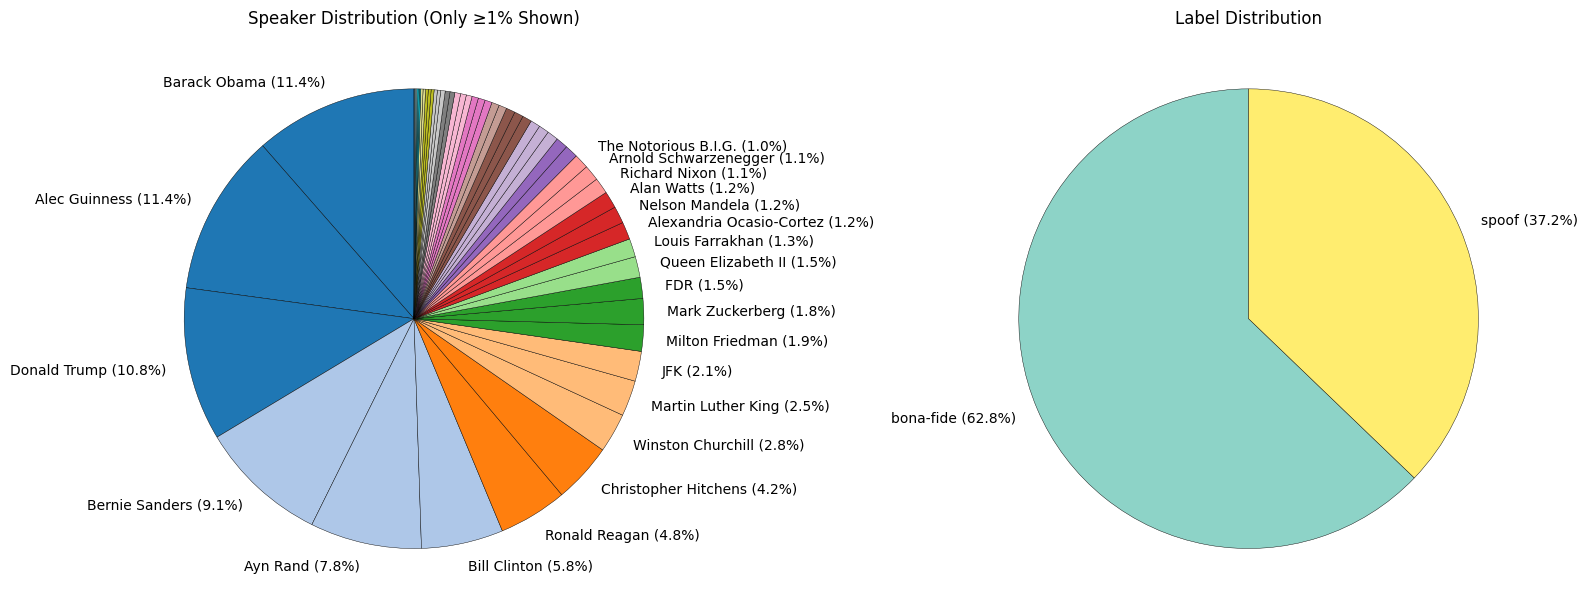

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

meta = pd.read_csv('../Data/itw_meta.csv')

# ============================
# Speaker 分布饼图
# ============================
speaker_counts = meta['speaker'].value_counts()
total_speakers = speaker_counts.sum()
speaker_percentages = speaker_counts / total_speakers * 100

# 构造标签：只有占比 >= 1% 的显示 "名字 (占比%)"，否则空字符串
speaker_labels = [f"{spk} ({perc:.1f}%)" if perc >= 1 else ""
                  for spk, perc in zip(speaker_counts.index, speaker_percentages)]

# 使用 tab20 颜色映射生成颜色列表
speaker_colors = plt.cm.tab20(np.linspace(0, 1, len(speaker_counts)))

# ============================
# Label 分布饼图
# ============================
label_counts = meta['label'].value_counts()
total_labels = label_counts.sum()
label_percentages = label_counts / total_labels * 100

# 构造标签：所有标签均显示 "名字 (占比%)"
label_labels = [f"{lab} ({perc:.1f}%)" for lab, perc in zip(label_counts.index, label_percentages)]

# 使用 Set3 颜色映射生成颜色列表
label_colors = plt.cm.Set3(np.linspace(0, 1, len(label_counts)))

# 创建 1 行 2 列的子图
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# 设置 wedge 边框属性
wedgeprops = dict(edgecolor="black", linewidth=0.3)

# 绘制 speaker 饼图
axs[0].pie(speaker_counts, labels=speaker_labels, startangle=90,
           colors=speaker_colors, wedgeprops=wedgeprops)
axs[0].set_title("Speaker Distribution (Only ≥1% Shown)")

# 绘制 label 饼图
axs[1].pie(label_counts, labels=label_labels, startangle=90,
           colors=label_colors, wedgeprops=wedgeprops)
axs[1].set_title("Label Distribution")

plt.tight_layout()

# 保存图像为高分辨率文件（dpi=1000，边界紧凑）
# plt.savefig("meta_distribution.png", dpi=400, bbox_inches='tight')
plt.show()


In [93]:
import os
import librosa
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

# 定义包含 wav 文件的目录
wav_dir = '../Data/generated_audio/ljspeech_waveglow'

# 收集所有 wav 文件的完整路径
wav_files = []
for root, dirs, files in os.walk(wav_dir):
    for file in files:
        if file.lower().endswith('.wav'):
            wav_files.append(os.path.join(root, file))

print(f"总共找到 {len(wav_files)} 个 wav 文件.")


# 定义加载 wav 文件的函数
def load_wav(file_path):
    try:
        data, sr = librosa.load(file_path, sr=16000)
        return file_path, data, sr
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return file_path, None, None


# 使用多线程加载数据
results = []
with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(load_wav, fp) for fp in wav_files]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Loading WAV files"):
        results.append(future.result())

# 现在 results 列表中包含了每个文件的 (file_path, data, sr)
print("加载完成。")


总共找到 13100 个 wav 文件.


Loading WAV files:   0%|          | 0/13100 [00:00<?, ?it/s]

加载完成。


In [111]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import toeplitz
from tqdm.notebook import tqdm
import pandas as pd


# 自定义 LPC 计算函数（基于自相关法）
def compute_lpc(signal, order=12):
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(signal) - 1:]
    R = autocorr[:order + 1]
    R_matrix = toeplitz(R[:-1])
    r_vector = -R[1:]
    try:
        lpc_coeffs = np.linalg.solve(R_matrix, r_vector)
    except np.linalg.LinAlgError:
        lpc_coeffs = np.zeros(order)
    lpc_coeffs = np.concatenate(([1.0], lpc_coeffs))
    return lpc_coeffs


# 根据 LPC 系数计算 LPCC（线性预测倒谱系数）
def compute_lpcc(lpc_coeffs, num_ceps=13):
    lpcc = np.zeros(num_ceps)
    lpcc[0] = 0
    for n in range(1, num_ceps):
        sum_val = 0
        for k in range(1, n):
            sum_val += (k / n) * lpcc[k] * lpc_coeffs[n - k]
        lpcc[n] = lpc_coeffs[n] + sum_val
    return lpcc


# 根据 LPC 系数计算 LSF（线谱频率）
def compute_lsf(lpc_coeffs, sr):
    roots = np.roots(lpc_coeffs)
    roots = roots[np.imag(roots) >= 0]
    angles = np.angle(roots)
    lsf_freqs = np.sort(angles * sr / (2 * np.pi))
    return lsf_freqs


def visualize_audio_subplots(file_path, audio, sr, save_path=None):
    """
    绘制音频的多种可视化图形（subplot 形式），排列如下：
      [0] 波形图 (Waveform with silence markers)
      [1] 频谱图 (Spectrogram)
      [2] Mel-频谱图
      [3] MFCC 图
      [4] 色度图 (Chromagram)
      [5] CQT 图
      [6] LSF (Bar 图)
      [7] LPC 系数 (Stem Plot)
      [8] LPCC 系数 (Stem Plot)
      [9] FFT Magnitude 直方图
      [10] FFT Magnitude 小提琴图
      [11] FFT Magnitude 箱线图
    """
    n_fft = 1024
    hop_length = 256

    # 创建 4x3 子图（共12个），后面将留空一个
    fig, axs = plt.subplots(4, 3, figsize=(30, 18))
    axs = axs.flatten()

    # ---------------------------
    # [0] 波形图 (Waveform)
    librosa.display.waveshow(audio, sr=sr, ax=axs[0], color='steelblue', alpha=0.8)
    axs[0].set_title(f"Waveform: {os.path.basename(file_path)}", color='darkblue')
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    frame_length = 2048
    energy = np.array([np.sum(np.abs(audio[i:i + frame_length] ** 2)) for i in range(0, len(audio), hop_length)])
    energy_threshold = np.median(energy) * 0.5
    silence_frames = np.where(energy < energy_threshold)[0]
    silence_times = (silence_frames * hop_length) / sr
    axs[0].scatter(silence_times, np.zeros_like(silence_times), color='green', marker='_', label='Silence')
    axs[0].legend()

    # ---------------------------
    # [1] 频谱图 (Spectrogram)
    D = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    img_spec = librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log',
                                        hop_length=hop_length, cmap='magma', ax=axs[1])
    axs[1].set_title("Spectrogram", color='darkred')
    fig.colorbar(img_spec, ax=axs[1], format="%+2.f dB")

    # ---------------------------
    # [2] Mel-频谱图
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft,
                                       hop_length=hop_length, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    img_mel = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel',
                                       hop_length=hop_length, cmap='viridis', ax=axs[2])
    axs[2].set_title("Mel-Spectrogram", color='darkgreen')
    fig.colorbar(img_mel, ax=axs[2], format="%+2.f dB")

    # ---------------------------
    # [3] MFCC 图
    mfcc = librosa.feature.mfcc(S=S_db, n_mfcc=13)
    img_mfcc = librosa.display.specshow(mfcc, sr=sr, x_axis='time',
                                        hop_length=hop_length, cmap='coolwarm', ax=axs[3])
    axs[3].set_title("MFCC", color='purple')
    fig.colorbar(img_mfcc, ax=axs[3])

    # ---------------------------
    # [4] 色度图 (Chromagram)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    img_chroma = librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma',
                                          hop_length=hop_length, cmap='cool', ax=axs[4])
    axs[4].set_title("Chromagram", color='teal')
    fig.colorbar(img_chroma, ax=axs[4])

    # ---------------------------
    # [5] CQT 图
    C = np.abs(librosa.cqt(y=audio, sr=sr))
    C_db = librosa.amplitude_to_db(C, ref=np.max)
    img_cqt = librosa.display.specshow(C_db, sr=sr, x_axis='time', y_axis='cqt_hz',
                                       cmap='plasma', ax=axs[5])
    axs[5].set_title("CQT", color='darkviolet')
    fig.colorbar(img_cqt, ax=axs[5], format="%+2.f dB")

    # ---------------------------
    # [6] LSF (Bar Plot)
    lpc_order = 12
    lpc_coeffs = compute_lpc(audio, order=lpc_order)
    lsf_freqs = compute_lsf(lpc_coeffs, sr)
    axs[6].bar(range(len(lsf_freqs)), lsf_freqs, color='mediumseagreen')
    axs[6].set_title("LSF Frequencies", color='brown')
    axs[6].set_xlabel("Index")
    axs[6].set_ylabel("Frequency (Hz)")

    # ---------------------------
    # [7] LPC 系数 (Stem Plot)
    markerline, stemlines, baseline = axs[7].stem(np.arange(len(lpc_coeffs)), lpc_coeffs)
    axs[7].set_title("LPC Coefficients", color='navy')
    axs[7].set_xlabel("Coefficient Index")
    axs[7].set_ylabel("Value")

    # ---------------------------
    # [8] LPCC 系数 (Stem Plot)
    lpcc_coeffs = compute_lpcc(lpc_coeffs, num_ceps=lpc_order + 1)
    markerline, stemlines, baseline = axs[8].stem(np.arange(len(lpcc_coeffs)), lpcc_coeffs)
    axs[8].set_title("LPCC Coefficients", color='darkorange')
    axs[8].set_xlabel("Coefficient Index")
    axs[8].set_ylabel("Value")

    # ---------------------------
    # [9] FFT Magnitude 直方图
    fft_spectrum = np.abs(np.fft.rfft(audio))
    nonzero_magnitude = fft_spectrum[fft_spectrum > 0]
    df_fft = pd.DataFrame({'Magnitude': nonzero_magnitude})
    sns.histplot(df_fft['Magnitude'], bins=50, ax=axs[9], color='olive', kde=True)
    axs[9].set_title("Histogram (FFT Magnitude)", color='darkslategray')

    # ---------------------------
    # [10] FFT Magnitude 小提琴图
    sns.violinplot(y='Magnitude', data=df_fft, ax=axs[10], color='skyblue')
    axs[10].set_title("Violin Plot (FFT Magnitude)", color='darkcyan')

    # ---------------------------
    # [11] FFT Magnitude 箱线图
    sns.boxplot(y='Magnitude', data=df_fft, ax=axs[11], color='lightcoral')
    axs[11].set_title("Box Plot (FFT Magnitude)", color='maroon')

    plt.tight_layout()

    # 为每个子图增加边框：遍历所有轴，并设置每个边框的颜色和线宽
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

    # if save_path is not None:
    #     plt.savefig(save_path, dpi=600)

    plt.show()



Visualizing file 101/3: ./generated_audio/ljspeech_waveglow/LJ043-0149.wav


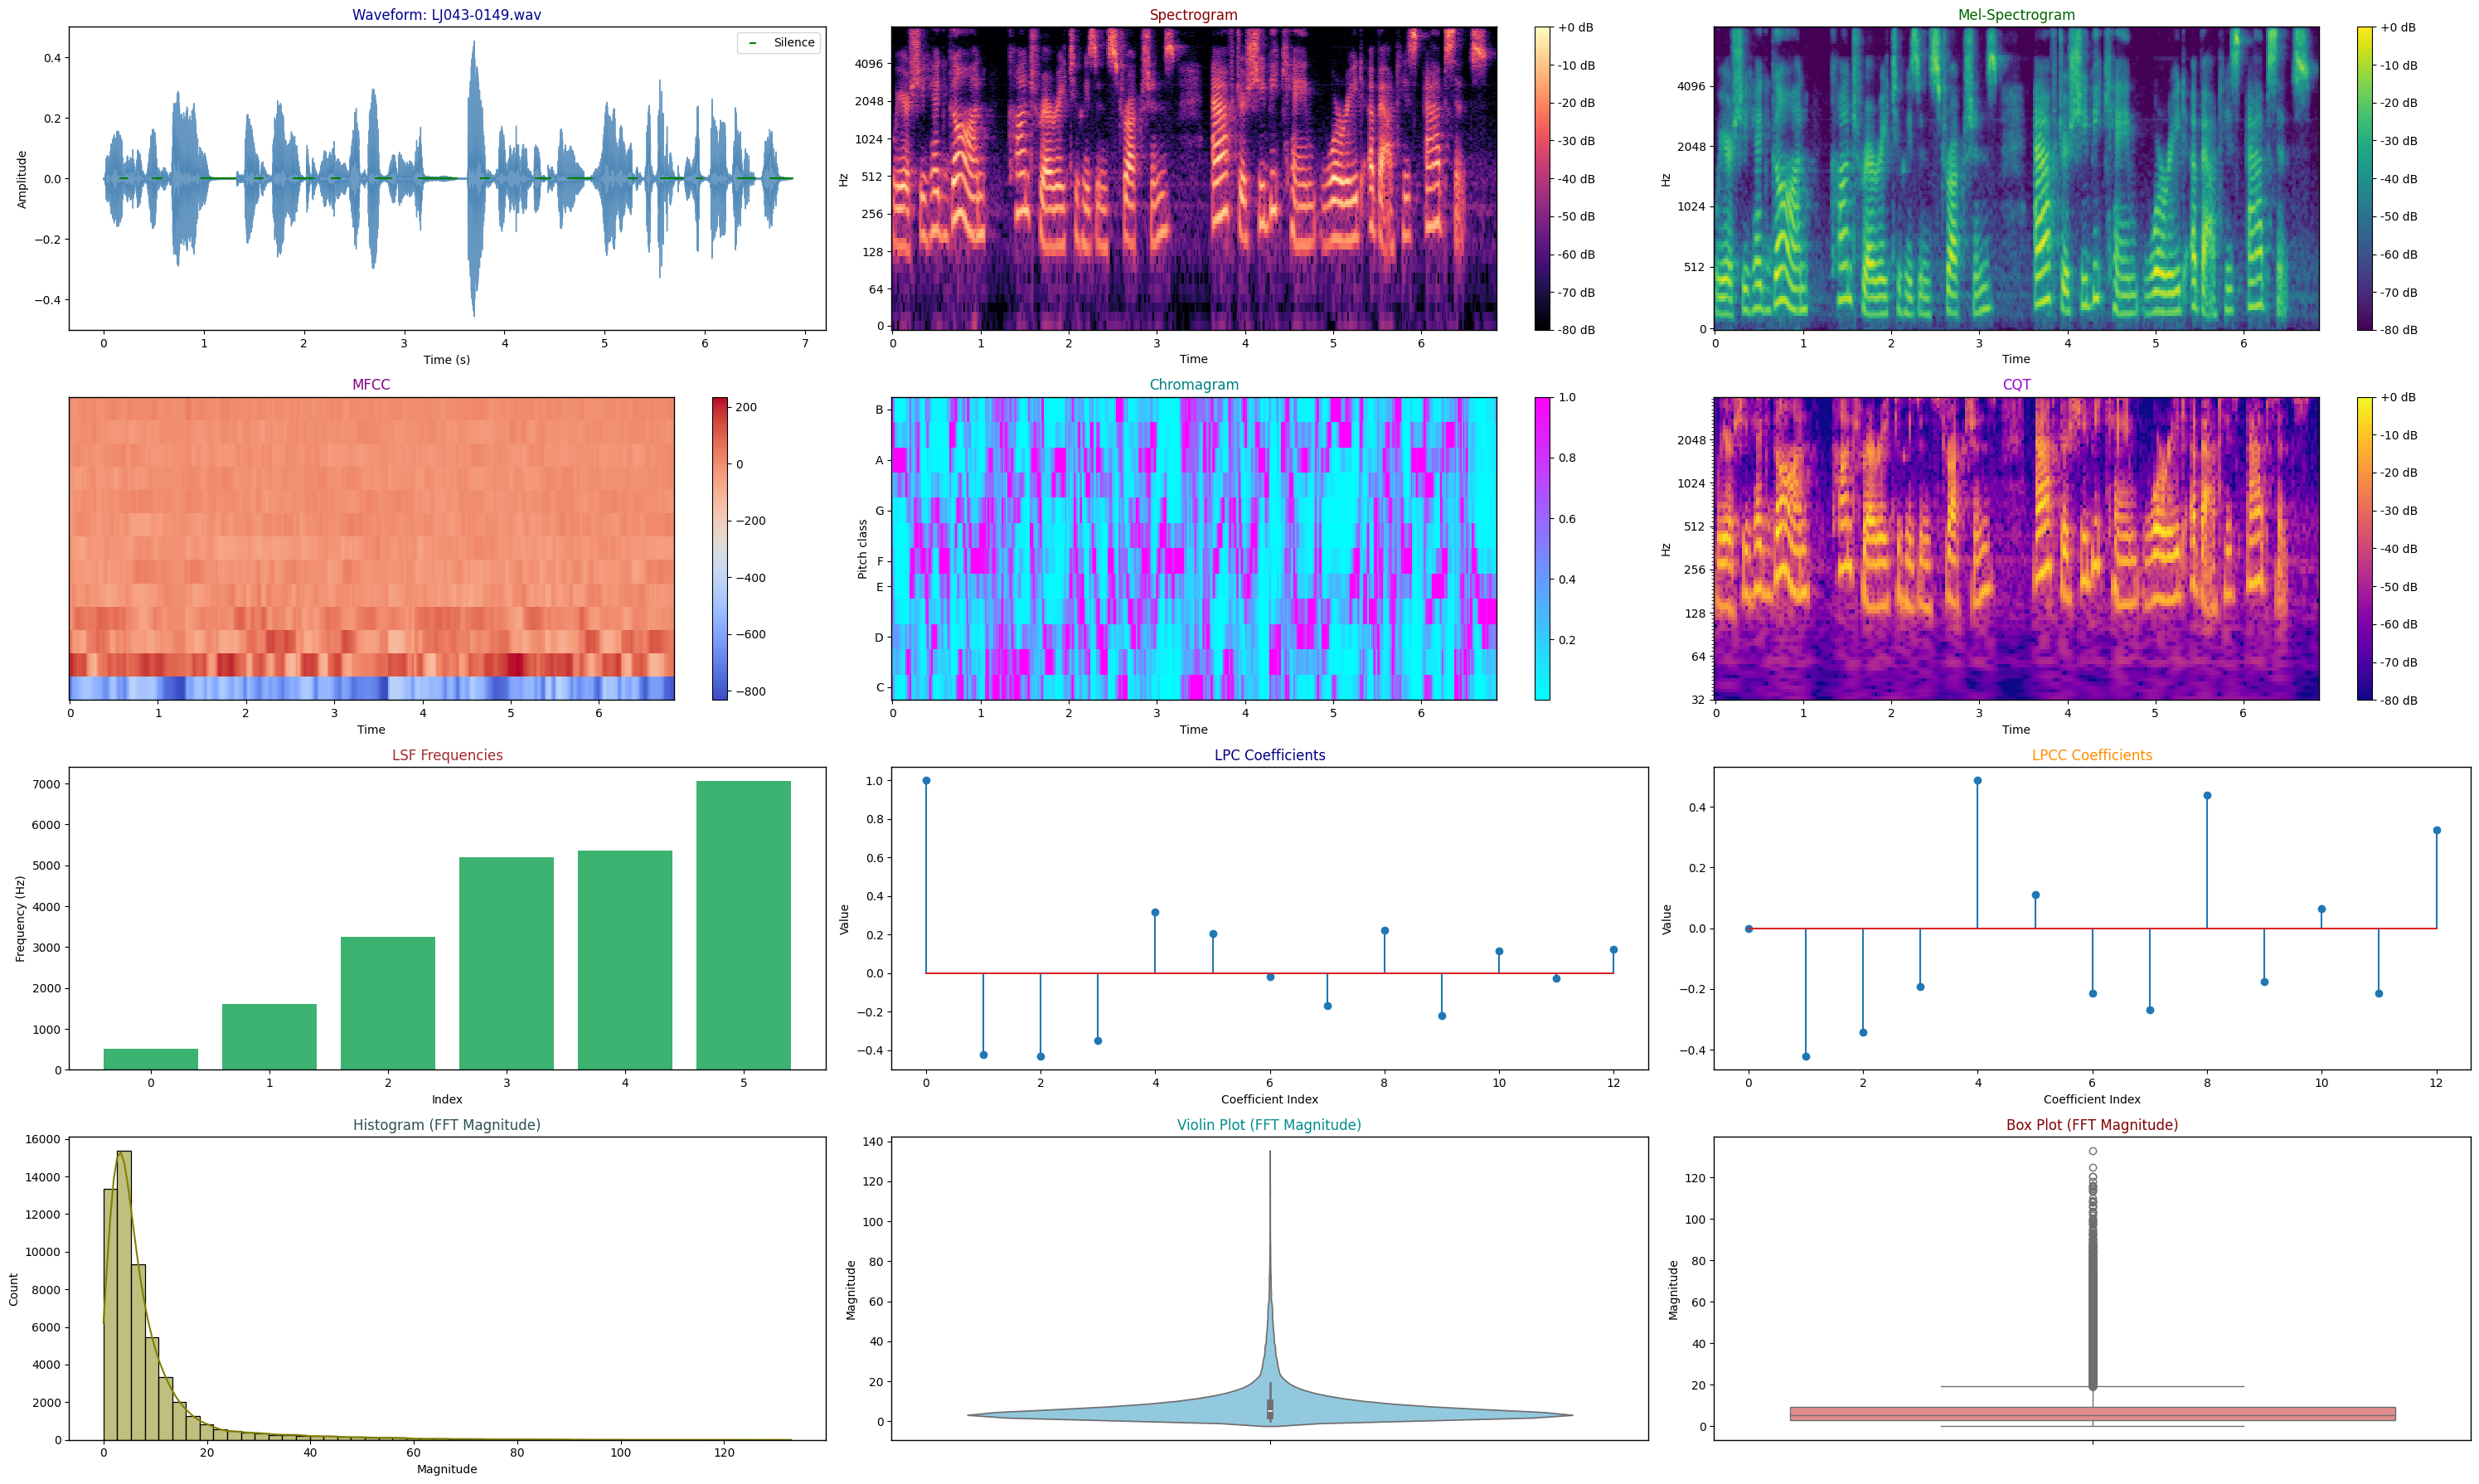

In [112]:

idx = 100
file_path, data, sr = results[idx]


def visual_plot(i, file_path, data, sr):
    print(f"\nVisualizing file {i + 1}/{min(len(results), 3)}: {file_path}")
    visualize_audio_subplots(file_path, data, sr, save_path='audio_visualization.png')


visual_plot(idx, file_path, data, sr)
